In [84]:
from custom_dataset.segdataset import InstanceSegmentationDataset
from transformers import SegformerImageProcessor
from torch.utils.data import DataLoader
import json
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
import evaluate
import logging
from utils import rs_utils

In [85]:
root_dir = '/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe'
#----------------------
# reduce_labels should be False !! 

image_processor = SegformerImageProcessor(reduce_labels=False)

train_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)


json_file = '/disk3/eric/dataset/VISION_SOFS/WEAPON_4/segmentation_pipe/train/_annotations.coco.json'
with open(json_file, 'r') as f:
    data = json.load(f)
#--- 
id2label = {
    0:data['categories'][0]['name'],
    1:data['categories'][1]['name'],
    2:data['categories'][2]['name'],
    3:data['categories'][3]['name'],
    4:data['categories'][4]['name']
}
label2id = {v: k for k, v in id2label.items()}


# define model
from transformers import SegformerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=5,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

# best model save. 
#model.load_state_dict(torch.load("/disk3/eric/checkpoints/military_fewshot_seg/segformer_best_epoch_10_miou_0.9311.pt"))
#----
model.load_state_dict(torch.load("/disk3/eric/checkpoints/military_fewshot_seg/001_mit-b5_segformer_best_epoch_7_miou_0.7145.pt"))


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M2A1Slammer2__part_13.png


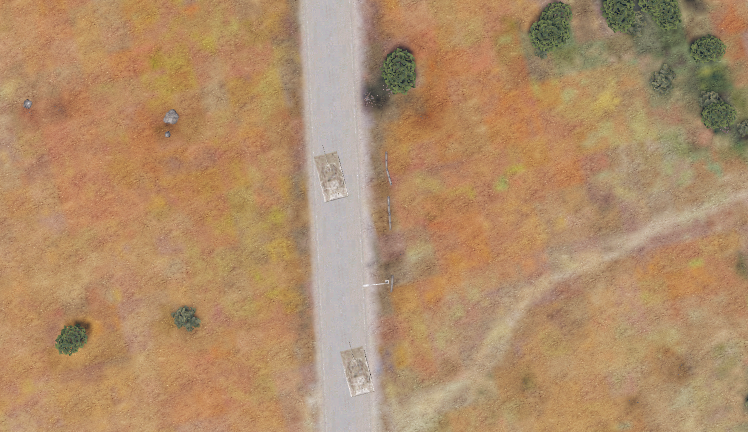

In [86]:
import random
from PIL import Image
img_root = "/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images"
rand_id = random.randint(0,len(os.listdir("/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images")))
img_name = os.listdir(img_root)[rand_id]
image = Image.open(os.path.join(img_root, img_name))
image

In [87]:
image.size

(748, 432)

In [88]:
from torchvision import transforms
transform = transforms.Compose([
    # Resize the image to the specified size
    transforms.Resize((512, 512)),  # (height, width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [89]:
transformed_image = transform(image)

In [90]:
transformed_image.shape

torch.Size([3, 512, 512])

In [91]:
transformed_image_ = transformed_image.unsqueeze(0)

In [92]:
transformed_image_.shape

torch.Size([1, 3, 512, 512])

In [93]:
model.eval()
outputs = model(transformed_image_)

In [94]:
shape_ = transformed_image.shape[-2:]

upsampled_logits = nn.functional.interpolate(
    outputs['logits'], size=shape_, mode="bilinear", align_corners=False)
predicted = upsampled_logits.argmax(dim=1)

In [95]:
predicted.shape

torch.Size([1, 512, 512])

In [96]:
import numpy as np
predicted_np = np.asarray( predicted.permute(1,2,0) )

In [97]:
id2label

{0: 'background',
 1: 'M2A1Slammer',
 2: 'M5SandstormMLRS',
 3: 'T140Angara',
 4: 'ZamakMRL'}

In [98]:
colormap = {
    0: (0, 0, 0),        # Black for background
    1: (255, 0, 0),      # Red for M2A1Slammer
    2: (0, 255, 0),      # Green for M5SandstormMLRS
    3: (0, 0, 255),      # Blue for T140Angara
    4: (255, 255, 0)     # Yellow for ZamakMRL
}

In [99]:
np.unique( predicted_np )

array([0, 1, 3])

In [100]:
rgb_image = np.repeat(predicted_np, 3, axis=-1)


In [101]:
for key,value in colormap.items():
    mask = (rgb_image == [key, key, key]).all(axis=-1)
    rgb_image[mask] = value   

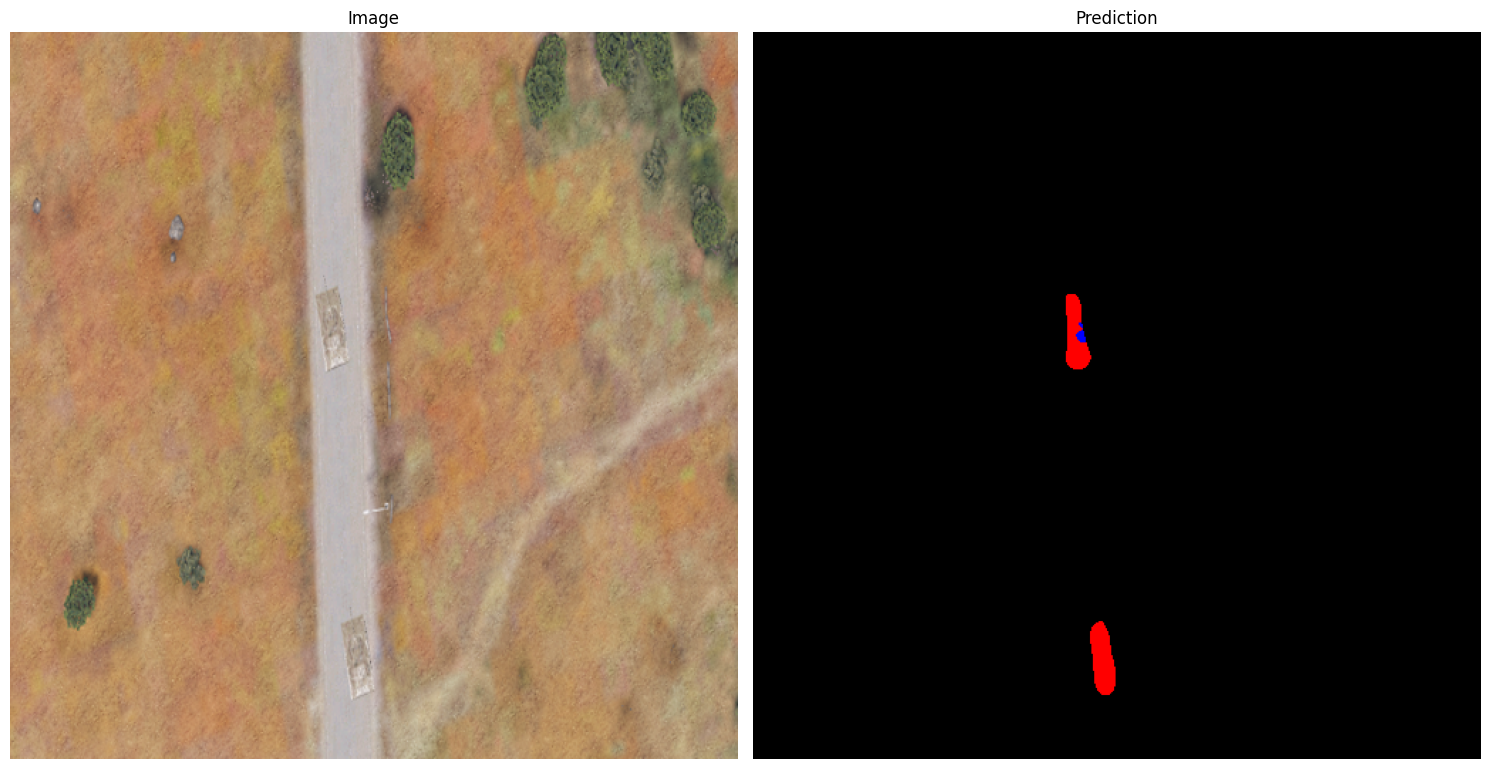

: 

In [ ]:
import matplotlib.pyplot as plt
# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 1 row, 2 columns

#----- image was resized
new_size = (512, 512)  # (width, height)

# Resize the image
resized_image = image.resize(new_size)  

# Display the first image in the first subplot
axes[0].imshow(resized_image)
axes[0].set_title("Image")  # Optional: Add a title
axes[0].axis("off")           # Turn off the axes for better visualization

# Display the second image in the second subplot
axes[1].imshow(rgb_image)
axes[1].set_title("Prediction")  # Optional: Add a title
axes[1].axis("off")           # Turn off the axes

# Show the combined figure
plt.tight_layout()
plt.show()